In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg
!python -m spacy link en_core_web_md en
!pip install -U spacy-lookups-data
!python -m spacy download xx_ent_wiki_sm
!pip install -U spacy[cuda92]
!pip install tika
!pip install newspaper3k
!curl https://raw.githubusercontent.com/codelucas/newspaper/master/download_corpora.py | python3
!pip install wordcloud
!pip install textatistic
!pip install langdetect
# !pip install gTTS

### Install tika parser, pandas and modules for files 

In [ ]:
import os
import re
import string
import pandas as pd
pd.set_option('display.max_colwidth', 100)

from os import listdir
from os.path import isfile, join
from collections import Counter

from tika import parser # pip install tika
# from gtts import gTTS

import newspaper
from newspaper import Article
from newspaper import Config

from multiprocessing.dummy import Pool as ThreadPool

import spacy
# Load the small English model – spaCy is already imported
# nlp = spacy.load('en_core_web_sm')
from spacy import displacy
import en_core_web_sm
import en_core_web_md
# import en_core_web_lg
nlp = en_core_web_md.load()
 
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

from wordcloud import WordCloud
from textatistic import Textatistic

###Import NLTK Lemmatizer and Stemmer

In [ ]:
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

### List of urls for download and parsing

Parsing URLs (minimum from list or maximum from file)

In [ ]:
# First minimal list
# raw_urls = """
# https://proglib.io/p/best-format-on-cv/
# https://blog.bitsrc.io/15-app-ideas-to-build-and-level-up-your-coding-skills-28612c72a3b1
# https://proglib.io/p/python-interview/
# https://proglib.io/p/15-questions-for-programmers/
# https://dou.ua/lenta/interviews/first-job-in-sixteen/?from=comment-digest_bc&utm_source=transactional&utm_medium=email&utm_campaign=digest-comments#1829186
# https://medium.com/better-programming/50-python-interview-questions-and-answers-f8e80d031bd3
# https://dev.to/javinpaul/50-data-structure-and-algorithms-problems-from-coding-interviews-4lh2
# https://towardsdatascience.com/53-python-interview-questions-and-answers-91fa311eec3f
# https://interviewing.io/
# https://www.datasciencecentral.com/profiles/blogs/answers-to-dozens-of-data-science-job-interview-questions
# """

# urls_list = raw_urls.split()
# print(urls_list)

# Second maximum list
# dataset of URLs - https://airtable.com/shrNtoOfPJVDcO3fG
my_urls = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Awesome Python Learning-Export URLs.csv', index_col=None)
my_url_list = list(my_urls['URL'])
print(my_url_list)

###Text cleaning function

In [ ]:
 def cleaning_raw_text(text_strings):
    safe_text = text_strings.encode('utf-8', errors='ignore')
    safe_text = safe_text.decode('utf-8')
    clean_text = str(safe_text).replace("\nn", "\n")
    clean_text = str(clean_text).replace("\nnn", "\n")
    clean_text = str(clean_text).replace("\n\n\n\n\n", "\n")
    clean_text = str(clean_text).replace("\n\n\n\n", "\n")
    clean_text = str(clean_text).replace("\n\n\n", "\n")
    clean_text = str(clean_text).replace("\n\n", "\n")
    clean_text = str(clean_text).replace("\n\n", "\n")
    clean_text = str(clean_text).replace("-----", "-")
    clean_text = str(clean_text).replace("----", "-")
    clean_text = str(clean_text).replace("---", "-")
    clean_text = ''.join(clean_text.split('\n', 1))
    return clean_text

## PDF download and parsing

### Current directory path

In [ ]:
path = os.path.abspath(os.curdir)
# path = os.path.abspath('/content/drive/My Drive/Colab Notebooks/Medium/')
path

### List of pdf files

In [ ]:
all_files = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith(".pdf")]
all_files

### File sizes

In [ ]:
file_sizes = [os.path.getsize(path + '/' + f) for f in listdir(path) if f.endswith(".pdf")]
file_sizes

### Function for reading pdf files

In [ ]:
 
def read_pdf(filename):
    file = parser.from_file(filename)
 
    return(file)

In [ ]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
config = Config()
config.browser_user_agent = user_agent
config.memoize_articles = False
config.fetch_images = False

# parsing minimum list
urls = ['https://proglib.io/p/best-format-on-cv/', 'https://blog.bitsrc.io/15-app-ideas-to-build-and-level-up-your-coding-skills-28612c72a3b1', 'https://proglib.io/p/python-interview/', 'https://proglib.io/p/15-questions-for-programmers/', 'https://dou.ua/lenta/interviews/first-job-in-sixteen/?from=comment-digest_bc&utm_source=transactional&utm_medium=email&utm_campaign=digest-comments#1829186', 'https://medium.com/better-programming/50-python-interview-questions-and-answers-f8e80d031bd3', 'https://dev.to/javinpaul/50-data-structure-and-algorithms-problems-from-coding-interviews-4lh2', 'https://towardsdatascience.com/53-python-interview-questions-and-answers-91fa311eec3f', 'https://interviewing.io/', 'https://www.datasciencecentral.com/profiles/blogs/answers-to-dozens-of-data-science-job-interview-questions']

articles_info_list = []

def getTxt(url):
    try:
        article = Article(url, config=config)
        article.download()
        article.parse()
        article.nlp()

        article_authors = article.authors
        article_title = article.title
        article_text = article.text
        article_summary = article.summary
        article_keywords = article.keywords
        article_movies = article.movies
        article_publish_date = article.publish_date
        article_source_url = article.source_url
        
        url_of_article = article.url
        
        txt = article.text
        txt = cleaning_raw_text(txt)

        tmp = [article_authors, article_title, txt, article_source_url, url_of_article, article_keywords, article_movies,  article_publish_date]            
        articles_info_list.append(tmp)
        
        # return txt

    except:
        print('***FAILED TO DOWNLOAD***', article.url)
    
# create multitreading: number of treads for downloading articles
pool = ThreadPool(4)

# open the urls in their own threads and return the results
# insted of my_url_list
results = pool.map(getTxt, urls) 

# close the pool and wait for the work to finish 
pool.close() 
pool.join()


In [ ]:
article_info_df = pd.DataFrame(articles_info_list, columns=['article_authors', 'article_title', 'txt', 'article_source_url', 'url_of_article', 'article_keywords', 'article_movies',  'article_publish_date'])
article_info_df.sort_values(by='article_title') 

In [ ]:
pdf_text_list = []
pagenumbers = []
path_and_files = [path + "/" + f for f in all_files]

def read_pdf_files(path=None):
    if path is not None:
        for i,file in enumerate(path):
            # creating an object
            try:
                text = read_pdf(file)
                pagenumbers.append(text['metadata']['xmpTPg:NPages'])
                t = [[k, v] for k, v in text.items()]
                
                text_strings = str(t[1][1])
                
            except:
                print(f"Something is wrong with reading PDF file #{i}")
                continue
            pdf_text_list.append(cleaning_raw_text(text_strings))


%time read_pdf_files(path=all_files) # instead of path_and_files

pdf_text_list


In [ ]:
import re
all_filenames_without_pdf = []
 
print(all_files)
for filename in all_files:
    # words = filename.split()
    # Create a list of words that are hashtags
    pattern = ".pdf"
    filename = re.sub(pattern, '', filename)
    all_filenames_without_pdf.append(filename)
 
print(all_filenames_without_pdf)

In [ ]:
columns = ['txt']
series = pd.DataFrame(pdf_text_list, index=None, columns=columns)
series['pagenumbers'] = pagenumbers
series['article_title'] = all_filenames_without_pdf
frames = [article_info_df, series]
data = pd.concat(frames)
data


In [ ]:
sentence_spans_list = []
for text_article in data['txt']:
    doc = nlp(text_article)
    sentence_spans = doc.sents
    sentence_spans_list.append(list(sentence_spans))

data['sentence_spans'] = sentence_spans_list
data.sentence_spans

###Replace text with regexp

In [ ]:
import re
 
cleaned_text_list = []
 
for article_df in  data.txt:
    clean_endlines = re.sub("\.\n", '.+++', article_df)
    clean_endlines = re.sub("!\n", '!+++', clean_endlines)
    clean_endlines = re.sub(":\n", '+++', clean_endlines)
    clean_endlines = re.sub("\n", ' ', clean_endlines)
    # pattern = "+++"
    # clean_endlines = re.sub(pattern, '\n', clean_endlines)
    enter_endlines = re.sub("\+{3}", "\n", clean_endlines)
    
 
    # Replace more then two links one after the other
    pattern = "[http]\S+\s[http]\S+\s[http]\S+"
    clean_two_http_links = re.sub(pattern, '', enter_endlines)
    # print(clean_two_http_links)
 
 
    # Clean dates in headers
    
    pattern = "(\d{1,2}\.\d{2}\.\d{4})(.)+(\d{1,2}\/\d{1,2})"
    clean_http_and_pagenumbers = re.sub(pattern, '', clean_two_http_links)
    cleaned_text_list.append(clean_http_and_pagenumbers)
    
data["cleaned_body_text"] = cleaned_text_list
data

###Read in text

In [ ]:
# Delete first symbol \n in the string
# data.txt[0]
# data.txt[0] = ''.join(str(data.txt[0]).split('\n', 1))
# data.txt[0]
# data

In [ ]:
from langdetect import detect_langs
languages = []

# Loop over the rows of the dataset and append
for row in data.cleaned_body_text:
    languages.append(detect_langs(row))

# Clean the list by splitting
languages = [str(lang).split(':')[0][1:] for lang in languages]

# # Assign the list to a new feature
data['language'] = languages

print(data)

###NLTK preprocessing, cleaning text, stemming, lemmatizing

In [ ]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text
 
data['body_text_nostop'] = data["cleaned_body_text"].apply(lambda x: clean_text(x.lower()))

def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text
 
data['body_text_stemmed'] = data['body_text_nostop'].apply(lambda x: stemming(x))
 
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text
 
data['body_text_lemmatized'] = data['body_text_nostop'].apply(lambda x: lemmatizing(x))
 
data.head(10)

### Most common words

In [ ]:
most_common_list = []
for data_row in data['body_text_lemmatized']:
    # Create the bag-of-words: bow
    bow = Counter(data_row)
    word_bow = [word for word,cnt in bow.most_common(10)]
    # Print the 10 most common tokens
    most_common_list.append(word_bow)

data['most_common_words'] = most_common_list
data.head()

In [ ]:
data.info()
data.shape


### Remove long words

In [ ]:
def length(column):
    text = [item for item in column if len(item) < 14]
    # [item for row in column for item in row if len(item) > 14]
    return text
 
data['body_textlemm_nolongwords'] = data['body_text_lemmatized'].apply(lambda x: length(x))


###Create feature text, punctuation, nonstopwords:

*   text message length
*   % of text that is punctuation
*   non stop words



In [ ]:
data['body_len'] = data["txt"].apply(lambda x: len(x) - x.count(" "))
data['cleaned_body_len'] = data["cleaned_body_text"].apply(lambda x: len(x) - x.count(" "))
 
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    try:
        return round(count/(len(text) - text.count(" ")), 3)*100
    except:
        pass


# Create a feature char_count
data['cleaned_char_count'] = data["cleaned_body_text"].apply(len)

# Function that returns number of words in a string
def count_words(string):
    # Split the string into words
    words = string.split()
 
    # Return the number of words
    return len(words)
  
# Create a new feature word_count
data['word_count'] = data["cleaned_body_text"].apply(count_words)
 
data['cleaned_body_punct%'] = data["cleaned_body_text"].apply(lambda x: count_punct(x))
data['body_nonstop_len'] = data["body_text_nostop"].apply(lambda x: len(x) - x.count(" "))
data['body_stemm_len'] = data["body_text_stemmed"].apply(lambda x: len(x) - x.count(" "))
data['body_lemm_len'] = data["body_text_lemmatized"].apply(lambda x: len(x) - x.count(" "))
data['body_textlemm_nolongwords_len'] = data['body_textlemm_nolongwords'].apply(lambda x: len(x) - x.count(" "))
 
# length_words = data.body_textlemm_nolongwords.str.len()
# data['body_textlemm_nolongwords_len1'] = length_words


data

In [ ]:
# Import the needed packages


# Tokenize each item in the review column 
word_tokens = [word_tokenize(review) for review in data.cleaned_body_text]

# Print out the first item of the word_tokens list
print(word_tokens[0])

# Create an empty list to store the length of reviews
len_tokens = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

# Create a new feature for the lengh of each review
data['n_tokens'] = len_tokens
data['n_tokens']

In [ ]:
data['body_len'] = data['body_len'].dropna()
data

In [ ]:
# Drop all rows that are missing 'driver_gender'
data.dropna(subset=['body_len'], inplace=True)

# Count the number of missing values in each column (again)
print(data.isnull().sum())

# Examine the shape of the DataFrame
print(data.shape)

In [ ]:
data

In [ ]:
data.columns

## Visualization

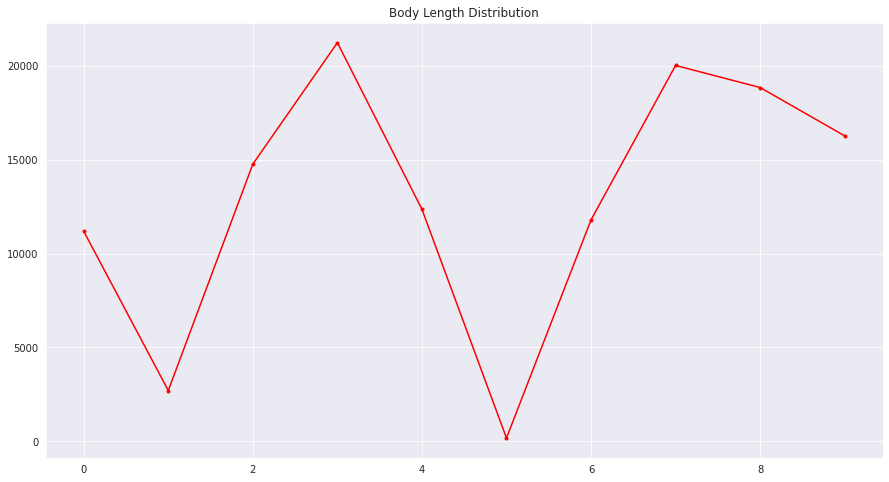

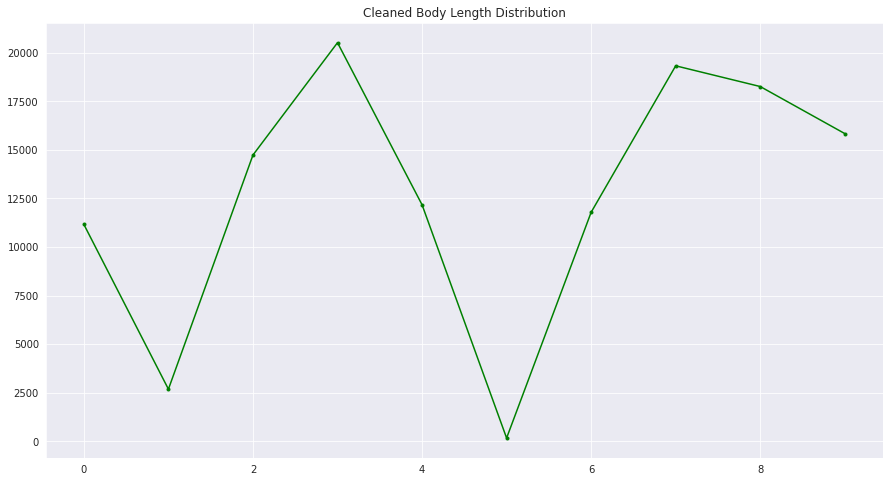

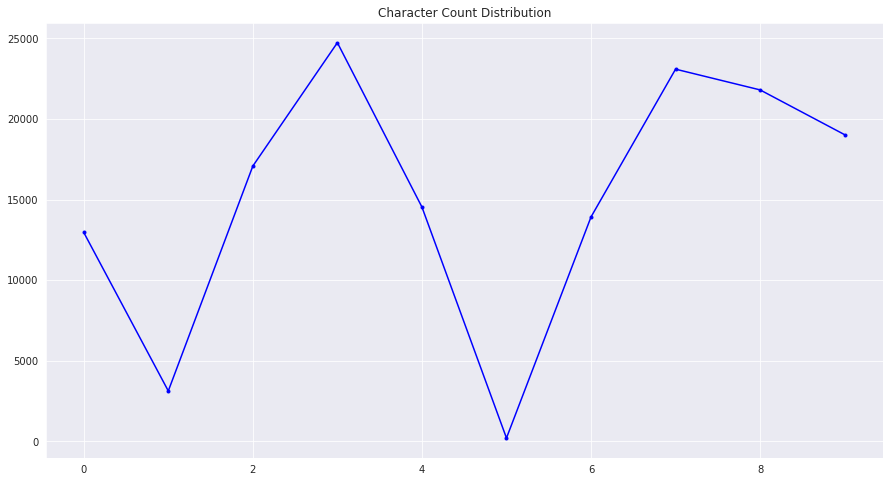

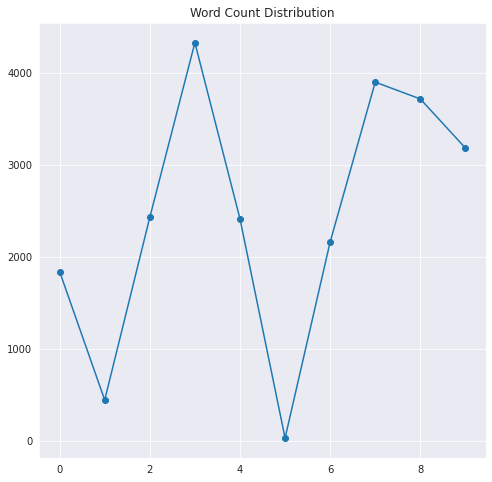

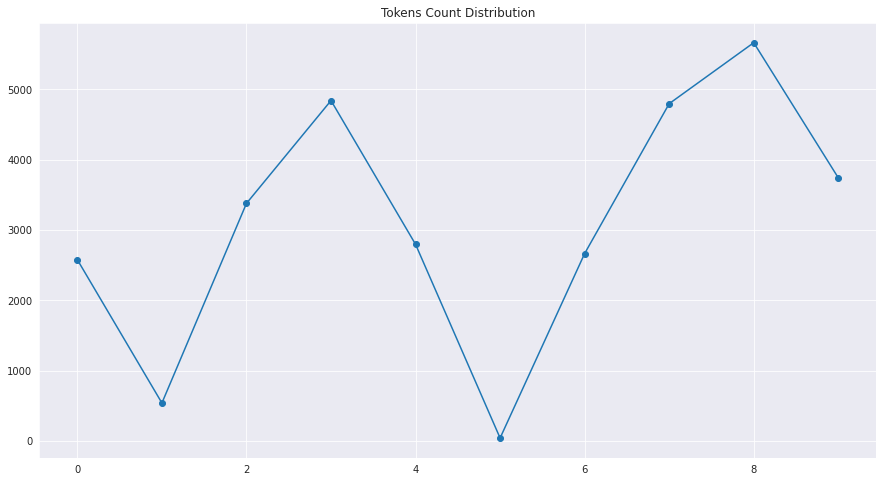

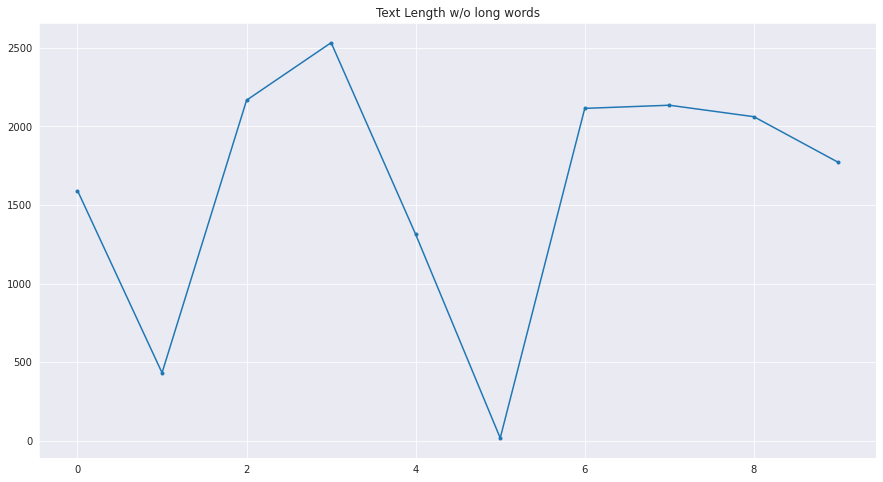

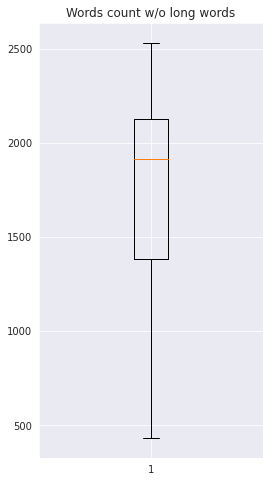

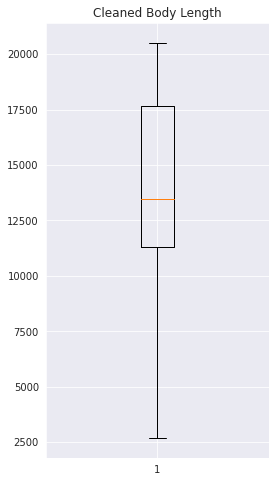

In [298]:
# fig, axs = plt.subplots(2, 2 ,gridspec_kw={'hspace': 0.5, 'wspace': 0.4})
# Create a Figure and an Axes with plt.subplots
fig = plt.figure(figsize=(15,8))

plt.plot(data['body_len'], color='r',  marker='.', label = 'body_len')
plt.title("Body Length Distribution")
plt.grid(True)
plt.show()
fig.set_size_inches([18, 10])
fig.savefig('figure_1.png')
fig = plt.figure(figsize=(15,8))
plt.plot(data['cleaned_body_len'], color='g', marker='.', label = 'cleaned_body_len')
plt.title("Cleaned Body Length Distribution")
plt.grid(True)
plt.show()
fig = plt.figure(figsize=(15,8))
plt.plot(data['cleaned_char_count'], color='b', marker='.', label = 'cleaned_char_count')
plt.title("Character Count Distribution")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(8,8))
plt.plot(data['word_count'], marker='o', label = 'word_count')
plt.title("Word Count Distribution")
plt.grid(True)
plt.show()
fig = plt.figure(figsize=(15,8))
plt.plot(data['n_tokens'], marker='o', label = 'n_tokens')
plt.title("Tokens Count Distribution")
plt.grid(True)
plt.show()
fig = plt.figure(figsize=(15,8))
# ax2.plot(data['body_lemm_len'], marker='v', label = 'body_lemm_len')
plt.plot(data['body_textlemm_nolongwords_len'], marker='.', label = 'textlemm_nolongwords_len')
plt.title("Text Length w/o long words")
plt.grid(True)
plt.show()


# plt.scatter(data['word_count'], data['body_textlemm_nolongwords_len'])
# plt.show()
fig = plt.figure(figsize=(4,8))

plt.boxplot(data['body_textlemm_nolongwords_len'], showfliers=False)
plt.title("Words count w/o long words")
plt.show()
fig.set_size_inches([18, 10])
fig.savefig('figure_2.png')

fig = plt.figure(figsize=(4,8))

plt.boxplot(data['cleaned_body_len'], showfliers=False)
plt.title("Cleaned Body Length")
plt.show()
fig.set_size_inches([18, 10])
fig.savefig('figure_3.png')


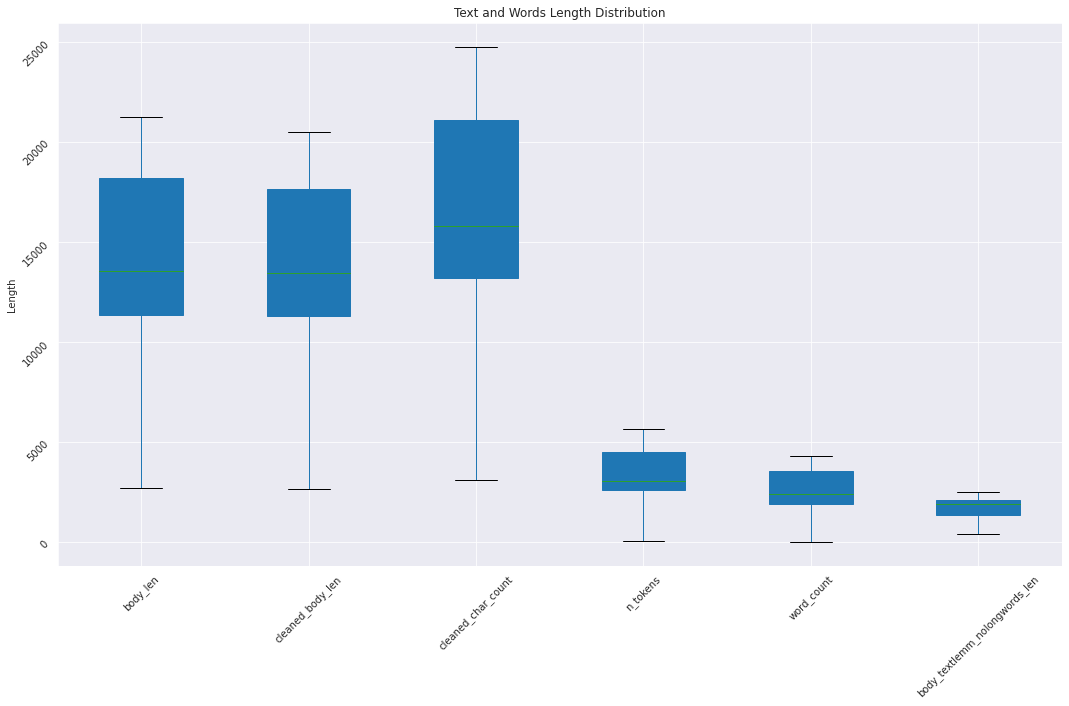

In [299]:
def boxplot_default():
    
    fig = plt.figure(figsize=(15,8))
    
    body_length = data[['body_len','cleaned_body_len', 'cleaned_char_count', 'n_tokens', 'word_count', 'body_textlemm_nolongwords_len']]
    body_length.boxplot(showfliers=False, patch_artist=True)
    
    plt.ylabel('Length')
    plt.title('Text and Words Length Distribution')
    plt.tick_params(labelrotation = 45)
    fig.set_size_inches([18, 10])
    fig.savefig('figure_4.png')
    plt.show()
    

boxplot_default()

In [ ]:
fig, ax = plt.subplots(figsize=(15,90))
a= data['article_source_url'].value_counts()
species = a.index
count = a.values
sns.barplot(y = species, x=count, label = 'value_counts')
plt.show()
fig.set_size_inches([18, 100])
fig.savefig('figure_5.png')

In [ ]:
bg_color = (0.88,0.85,0.95)
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
fig, ax = plt.subplots(1, figsize=(20,15))

sns.heatmap(data.corr(), ax=ax, cmap='coolwarm',  robust=True, annot=True, fmt=".1f")
fig.set_size_inches([18, 10])
fig.savefig('figure_6.png')
plt.show()

In [ ]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=data.cleaned_body_len)
plt.show()


sns.FacetGrid(data, hue="article_source_url", height=8).map(plt.scatter, 'cleaned_body_len', "word_count")
plt.show()
fig.set_size_inches([18, 10])
fig.savefig('figure_7.png')


In [ ]:
# plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(15,8))

# Add data: "co2" on x-axis, "relative_temp" on y-axis
ax.scatter(x=data['cleaned_body_len'], y=data['word_count'], c=data.index, alpha=0.5)

# Set the x-axis label to "CO2 (ppm)"
ax.set_xlabel("cleaned_body_len")

# Set the y-axis label to "Relative temperature (C)"
ax.set_ylabel("word_count")

plt.show()
fig.set_size_inches([18, 10])
plt.savefig('figure_8.png')

In [ ]:
for i, s in enumerate(data['cleaned_body_text']):
    # Create and generate a word cloud image
    my_cloud = WordCloud(background_color='white', stopwords=stopwords).generate(str(s))
 
    # Display the generated wordcloud image
    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis("off")
 
    # Don't forget to show the final image
    print('---------------------------------')
    fig.set_size_inches([18, 10])
    plt.savefig(f'wordcloud/wordcloud_{i}.png')
    plt.show()

In [ ]:
for s in data['body_text_nostop']:
    ss = ' '.join(s)
    my_cloud = WordCloud(background_color='white').generate(str(ss))
    fig, ax = plt.subplots(figsize=(10,6))
    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    

In [ ]:
# Function that returns numner of hashtags in a string
def count_https(string):
    # Split the string into words
    words = string.split()
 
    # Create a list of words that are hashtags
    https = [word for word in words if word.startswith('http')]
 
    # Return number of hashtags
    return (len(https))
 
 
# Create a feature hashtag_count and display distribution
data['http_count'] = data["cleaned_body_text"].apply(count_https)
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data.index, data['http_count'])
plt.title('HTTP count distribution')
fig.set_size_inches([18, 10])
fig.savefig('figure_9.png')
plt.show()
 
 
# Function that returns number of mentions in a string
def count_mentions(string):
    # Split the string into words
    words = string.split()
 
    # Create a list of words that are mentions
    mentions = [word for word in words if word.startswith('@')]
 
    # Return number of mentions
    return (len(mentions))
 
 
# Create a feature mention_count and display distribution
data['mention_count'] = data["cleaned_body_text"].apply(count_mentions)
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data.index, data['mention_count'], color='green')
plt.title('@ Mention count distribution')
fig.set_size_inches([18, 10])
fig.savefig('figure_10.png')
plt.show()
# data['mention_count']

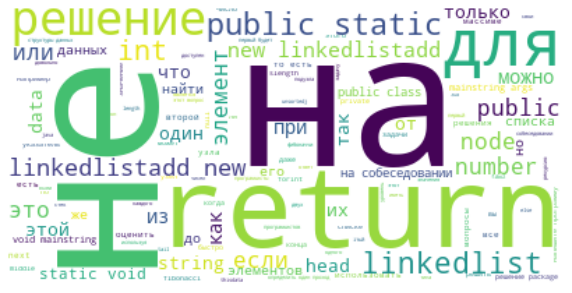

---------------------------------


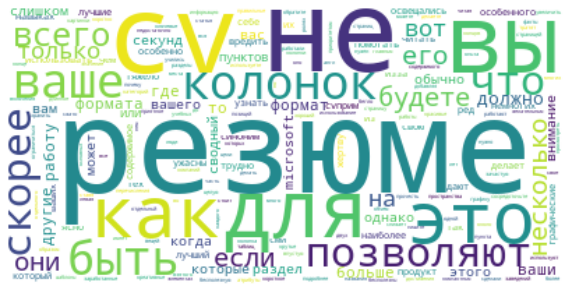

---------------------------------


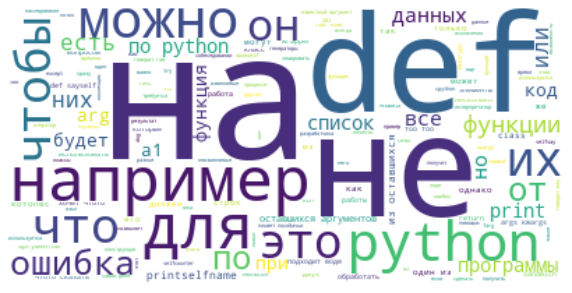

---------------------------------


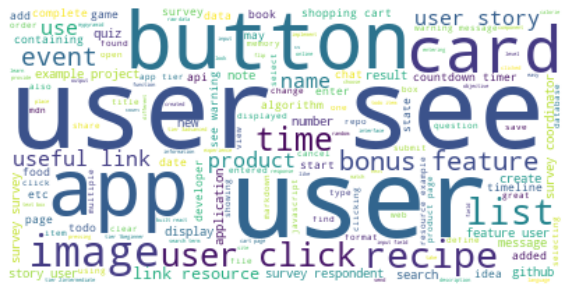

---------------------------------


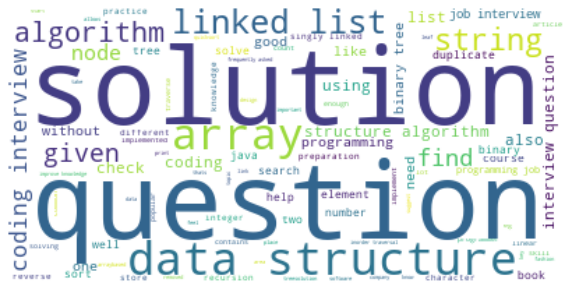

---------------------------------


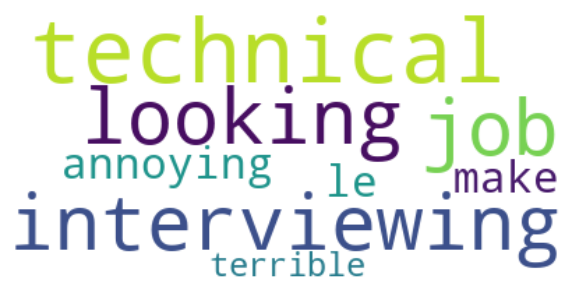

---------------------------------


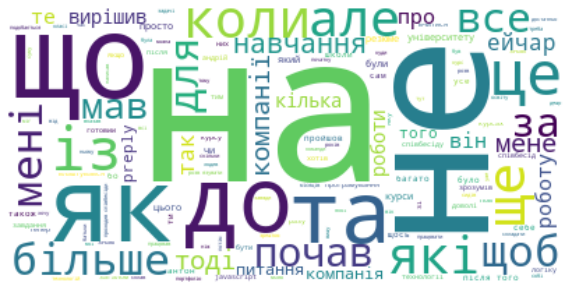

---------------------------------


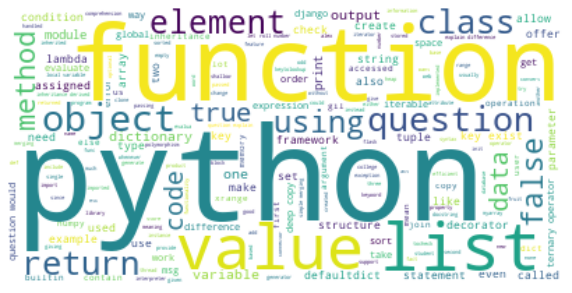

---------------------------------


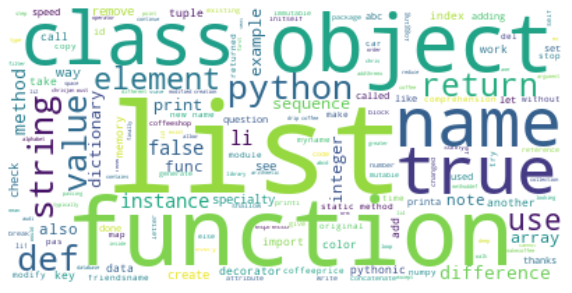

---------------------------------


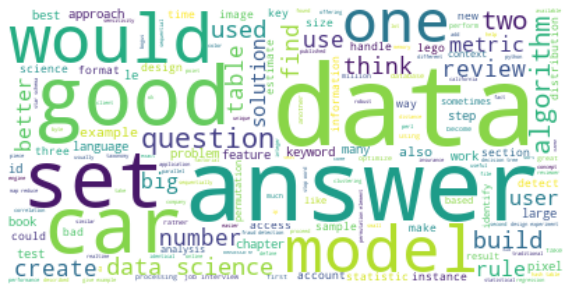

---------------------------------


In [297]:
for s in data.body_textlemm_nolongwords:
    # Create and generate a word cloud image
    ss = ' '.join(s)
    my_cloud = WordCloud(background_color='white', stopwords=stopwords).generate(str(ss))
 
    # Display the generated wordcloud image
    fig, ax = plt.subplots(figsize=(10,6))
    plt.imshow(my_cloud, interpolation='bilinear')
    plt.axis("off")
 
    # Don't forget to show the final image

    plt.show()
    print('---------------------------------')

## Reading Scores (Flesh and Gunning)

In [ ]:
# Import Textatistic

flesh_reading_scores = []
gunning_fog_scores = []
 
for article in data["cleaned_body_text"]:
    # Compute the readability scores
    try:
        readability_scores = Textatistic(article).scores
        flesch = readability_scores['flesch_score']
        gunning_fog = readability_scores['gunningfog_score']
    except:
        print('Error has occured')
        continue
    
    flesh_reading_scores.append(flesch)
    gunning_fog_scores.append(gunning_fog)

data["flesh_reading_scores"] = pd.Series(flesh_reading_scores)
 
# Loop through excerpts and compute gunning fog index

data["gunning_fog_scores"] = pd.Series(gunning_fog_scores)

plt.scatter(data["flesh_reading_scores"], data["gunning_fog_scores"])
plt.title('Reading Scores')
plt.xlabel('flesh_reading_scores')
plt.ylabel('gunning_fog_scores')
plt.show()

In [ ]:
proper_nouns_count = []
nouns_count = []
find_persons_list = []
for i, art1 in enumerate(data.cleaned_body_text):
    # Returns number of proper nouns
    def proper_nouns(text, model=nlp):
        # Create doc object
        doc = model(text)
        # Generate list of POS tags
        pos = [token.pos_ for token in doc]
    
        # Return number of proper nouns
        return pos.count('PROPN')
    proper_nouns_count.append(proper_nouns(art1, nlp))

    # Returns number of other nouns
    def nouns(text, model=nlp):
        # Create doc object
        doc = model(text)
        # Generate list of POS tags
        pos = [token.pos_ for token in doc]
    
        # Return number of other nouns
        return pos.count('NOUN')
    
    
    nouns_count.append(nouns(art1, nlp))



data['proper_nouns_count'] = proper_nouns_count
data['nouns_count'] = nouns_count

data

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(data.index, data['proper_nouns_count'], label='proper_nouns_count',color='brown')
plt.legend()
fig.set_size_inches([18, 10])
fig.savefig('figure_10.png')
plt.show()

fig, ax = plt.subplots(figsize=(15,8))
plt.scatter(data.index, data['proper_nouns_count'], label='nouns_count', color='blue')
# plt.plot(data['proper_nouns_count'], label='proper_nouns_count')
# plt.plot(data['nouns_count'], label='nouns_count')
plt.legend()
fig.set_size_inches([18, 10])
fig.savefig('figure_11.png')
plt.show()

In [ ]:
#TODO: Clean persons from fuzzy words and symbols

## Display some text with NLP Name Entity Recognitions

In [304]:
# doc = nlp(data.cleaned_body_text[3])
# # pprint([(X.text, X.label_) for X in doc.ents])
# pprint([(X, X.ent_iob_, X.ent_type_) for X in doc])

article = nlp(data.cleaned_body_text[4])
len(article.ents)
labels = [x.label_ for x in article.ents]
Counter(labels)
items = [x.text for x in article.ents]
Counter(items).most_common(10)
sentences = [x for x in article.sents]
displacy.render(nlp(str(article)), style='ent', jupyter = True, options = {'distance': 120})
# print(doc.ents)

In [ ]:
dict([(str(x), x.label_) for x in nlp(str(article)).ents])

[(x.orth_, x.pos_) for x in [y 
                                      for y
                                      in nlp(str(data.cleaned_body_text[3])) 
                                      if not y.is_stop and y.pos_ != 'PUNCT' if y.pos_ == 'DATE']]

In [ ]:
displacy.render(article, jupyter=True, style='ent')